## Notebook to remove unannotated frames from a dataset that has been partially annotated. All unannotated frames are moved into a new folder called 'unannotated', and a new json saved

In [34]:
import json
import os
import numpy as np
import pandas as pd
from collections import defaultdict


### Function to load and save datasets of the class dataset3D

In [36]:
def load_dataset(json_path):
    with open(json_path) as f:
        dataset = json.load(f)
    return dataset

def save_dataset(dataset, json_path):
    with open(json_path, 'w') as f:
        json.dump(dataset, f)

<Axes: >

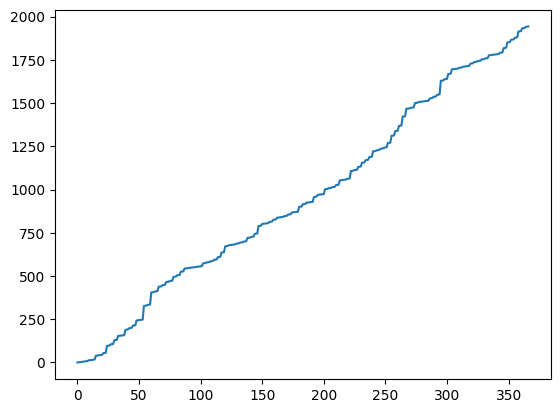

In [37]:
#scratch
json_file = r'C:\tr-dev\JARVIS-msi\Training\test_manyframes_training_sub\annotations\instances_train.json'
dataset = json.load(open(json_file))
annotations = dataset['annotations']
annotated_frames = pd.DataFrame(annotations)['image_id']
annotated_frames.plot()

In [38]:
#scratch
images = dataset['images']
images[0]['id']
images[0]['file_name']

'test_manyframes/Recording/Camera1_2024-03-01T11-00-00/Frame_38450.jpg'

## Function to create a subfolder and move selected file to that subfolder

In [39]:
def move_file_to_subdirectory(file_path, subdirectory):
    
    directory = os.path.dirname(file_path)
    subdirectory_path = os.path.join(directory, subdirectory)
    if not os.path.exists(subdirectory_path):
        os.makedirs(subdirectory_path)
    file_name = os.path.basename(file_path)
    new_file_path = os.path.join(subdirectory_path, file_name)
    os.rename(file_path, new_file_path)

### Function to find and filter the annotated frames

In [72]:
# Filter out frames without annotations. Automatically move the frames out of the corresponding folder.
def filter_frames(dataset, recording_dir):
    filtered_images = []
    filtered_annotations = []
    annotated_frame_ids = set()

    for ann in dataset['annotations']:
        annotated_frame_ids.add(ann['image_id'])
        filtered_annotations.append(ann)

    for img in dataset['images']:
        if img['id'] in annotated_frame_ids:
            filtered_images.append(img)
        else:
            file_path = os.path.join(recording_dir, img['file_name'])
            print('Sending ' + file_path + ' to ' + os.path.join(file_path, 'unannotated'))
            move_file_to_subdirectory(file_path, 'unannotated')
    for ann in dataset['annotations']:
        if ann['image_id'] in annotated_frame_ids:
            filtered_annotations.append(ann)


    dataset['images'] = filtered_images
    dataset['annotations'] = filtered_annotations

    return dataset



In [73]:
# Paths
data_dir = r'C:\tr-dev\JARVIS-msi\Training\test_manyframes_training'
annotations_dir = os.path.join(data_dir, 'annotations')
recording_dir = os.path.join(data_dir, 'train')
train_json_path = os.path.join(annotations_dir, 'instances_train.json')
filtered_train_json_path = os.path.join(annotations_dir, 'filtered_instances_train.json')

# Load datasets
train_dataset = load_dataset(train_json_path)

# Filter datasets
filtered_train_dataset = filter_frames(train_dataset, recording_dir)

# Save filtered datasets
save_dataset(filtered_train_dataset, filtered_train_json_path)

print("Filtered datasets saved successfully.")

Sending C:\tr-dev\JARVIS-msi\Training\test_manyframes_training\train\test_manyframes/Recording/Camera1_2024-03-01T11-00-00/Frame_2210.jpg to C:\tr-dev\JARVIS-msi\Training\test_manyframes_training\train\test_manyframes/Recording/Camera1_2024-03-01T11-00-00/Frame_2210.jpg\unannotated
Sending C:\tr-dev\JARVIS-msi\Training\test_manyframes_training\train\test_manyframes/Recording/Camera2_2024-03-01T11-00-00/Frame_2210.jpg to C:\tr-dev\JARVIS-msi\Training\test_manyframes_training\train\test_manyframes/Recording/Camera2_2024-03-01T11-00-00/Frame_2210.jpg\unannotated
Sending C:\tr-dev\JARVIS-msi\Training\test_manyframes_training\train\test_manyframes/Recording/Camera3_2024-03-01T11-00-00/Frame_2210.jpg to C:\tr-dev\JARVIS-msi\Training\test_manyframes_training\train\test_manyframes/Recording/Camera3_2024-03-01T11-00-00/Frame_2210.jpg\unannotated
Sending C:\tr-dev\JARVIS-msi\Training\test_manyframes_training\train\test_manyframes/Recording/Camera1_2024-03-01T11-00-00/Frame_12020.jpg to C:\tr-dev